In [1]:
import pandas as pd
import numpy as np
import keras
import warnings
warnings.filterwarnings(action="ignore")
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard,EarlyStopping

import sklearn.metrics as metrics
from keras.callbacks import LearningRateScheduler
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)

In [2]:
import os
import pandas as pd

MildDemented_dir = 'AugmentedAlzheimerDataset/MildDemented'
ModerateDemented_dir = 'AugmentedAlzheimerDataset/ModerateDemented'
NonDemented_dir = 'AugmentedAlzheimerDataset/NonDemented'
VeryMildDemented_dir = 'AugmentedAlzheimerDataset/VeryMildDemented'

filepaths = []
labels = []
dict_list = [MildDemented_dir, ModerateDemented_dir, NonDemented_dir, VeryMildDemented_dir]
class_labels = ['Mild Demented', 'Moderate Demented', 'Non Demented', 'Very MildDemented']

for i, j in enumerate(dict_list):
    flist = os.listdir(j)
    for f in flist:
        fpath = os.path.join(j, f)
        filepaths.append(fpath)
        labels.append(class_labels[i])

Fseries = pd.Series(filepaths, name="filepaths")
Lseries = pd.Series(labels, name="labels")
Alzheimer_data = pd.concat([Fseries, Lseries], axis=1)
Alzheimer_df = pd.DataFrame(Alzheimer_data)
print(Alzheimer_df.head())
print(Alzheimer_df["labels"].value_counts())

                                           filepaths         labels
0  AugmentedAlzheimerDataset/MildDemented/72b0f89...  Mild Demented
1  AugmentedAlzheimerDataset/MildDemented/c939cc0...  Mild Demented
2  AugmentedAlzheimerDataset/MildDemented/4d877a7...  Mild Demented
3  AugmentedAlzheimerDataset/MildDemented/cbc38a8...  Mild Demented
4  AugmentedAlzheimerDataset/MildDemented/a59b33a...  Mild Demented
labels
Non Demented         9600
Mild Demented        8960
Very MildDemented    8960
Moderate Demented    6464
Name: count, dtype: int64


In [3]:
train_images, test_images = train_test_split(Alzheimer_df, test_size=0.3, random_state=42)
train_set, val_set = train_test_split(Alzheimer_df, test_size=0.2, random_state=42)

In [4]:
print(train_set.shape)
print(test_images.shape)
print(val_set.shape)
print(train_images.shape)


(27187, 2)
(10196, 2)
(6797, 2)
(23788, 2)


In [5]:
image_gen = ImageDataGenerator(preprocessing_function= tf.keras.applications.mobilenet_v2.preprocess_input)
train = image_gen.flow_from_dataframe(dataframe= train_set,x_col="filepaths",y_col="labels",
                                      target_size=(244,244),
                                      color_mode='rgb',
                                      class_mode="categorical", #used for Sequential Model
                                      batch_size=32,
                                      shuffle=False            #do not shuffle data
                                     )
test = image_gen.flow_from_dataframe(dataframe= test_images,x_col="filepaths", y_col="labels",
                                     target_size=(244,244),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=32,
                                     shuffle= False
                                    )
val = image_gen.flow_from_dataframe(dataframe= val_set,x_col="filepaths", y_col="labels",
                                    target_size=(244,244),
                                    color_mode= 'rgb',
                                    class_mode="categorical",
                                    batch_size=32,
                                    shuffle=False
                                   )

Found 27187 validated image filenames belonging to 4 classes.
Found 10196 validated image filenames belonging to 4 classes.
Found 6797 validated image filenames belonging to 4 classes.


In [6]:
classes=list(train.class_indices.keys())
print (classes)

['Mild Demented', 'Moderate Demented', 'Non Demented', 'Very MildDemented']


In [7]:
def show_knee_images(image_gen):
    test_dict = test.class_indices
    classes = list(test_dict.keys())
    images, labels=next(image_gen) # get a sample batch from the generator
    plt.figure(figsize=(20,20))
    length = len(labels)
    if length<25:
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5,5,i+1)
        image=(images[i]+1)/2 #scale images between 0 and 1
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color="green",fontsize=16)
        plt.axis('off')
    plt.show()

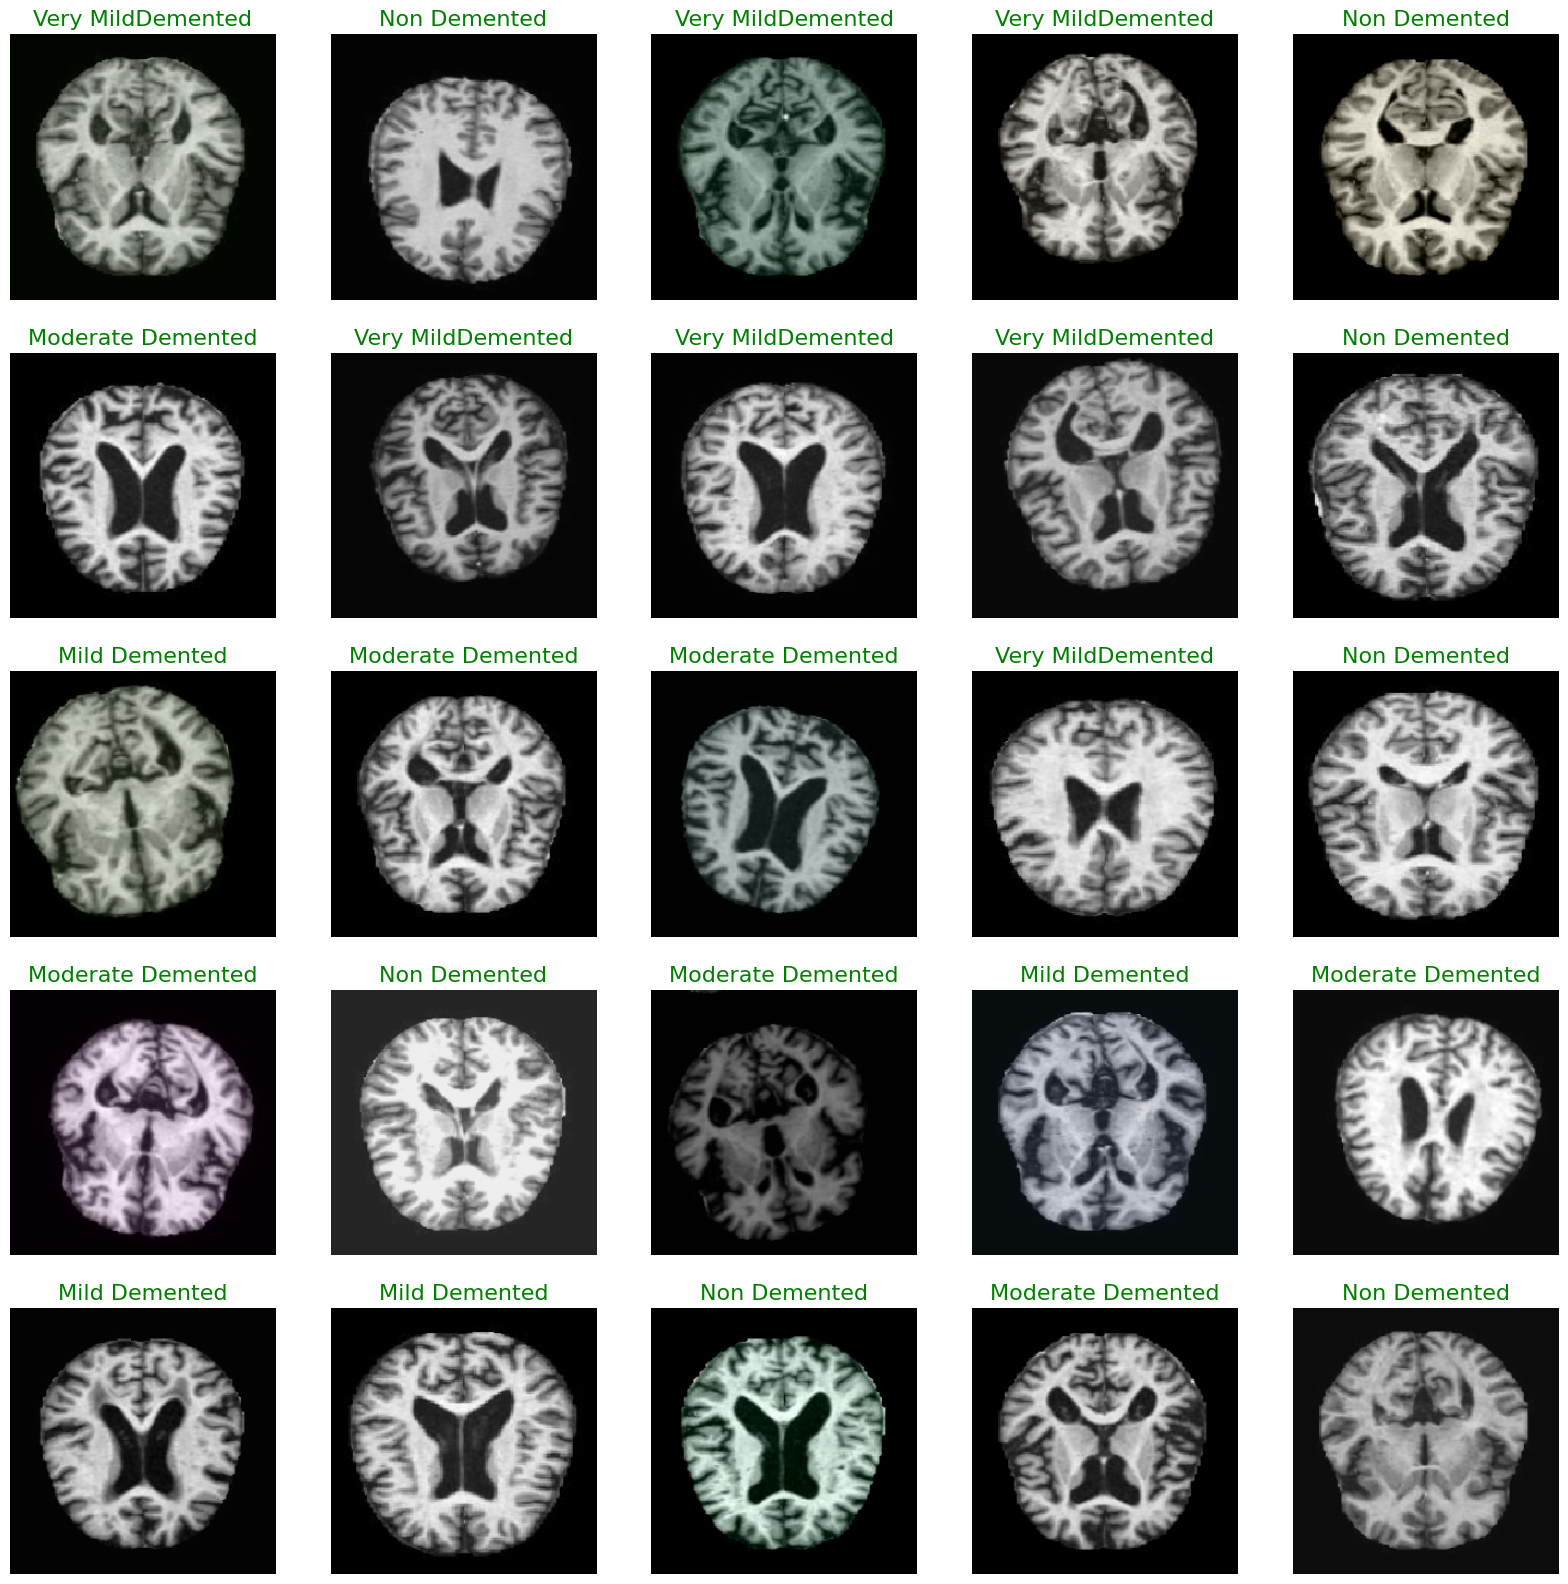

In [8]:
show_knee_images(train)

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dropout, Dense
from tensorflow.keras.applications import Xception
from tensorflow.keras.optimizers import Adamax

# Define input shape
img_shape = (244, 244, 3)

# Load Xception model without weights
base_model = Xception(weights=None, include_top=False, input_shape=img_shape)

# Load the downloaded weights manually
base_model.load_weights("xception_weights_tf_dim_ordering_tf_kernels_notop.h5")

# Freeze the base model layers (optional for transfer learning)
for layer in base_model.layers:
    layer.trainable = False

# Define the model
model = Sequential([
    base_model,
    Flatten(),
    Dropout(rate=0.3),
    Dense(128, activation='relu'),
    Dropout(rate=0.25),
    Dense(4, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adamax(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 8, 8, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    16,777,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,639,340 (143.58 MB)

 Trainable params: 16,777,860 (64.00 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [10]:
from tensorflow.keras.utils import plot_model
model.build(input_shape=(None, *img_shape))
tf.keras.utils.plot_model(model, show_shapes=True)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [11]:
history = model.fit(train, epochs=5, validation_data=val, validation_freq=1)

Epoch 1/5
850/850 ━━━━━━━━━━━━━━━━━━━━ 1651s 2s/step - accuracy: 0.3697 - loss: 2.1520 - val_accuracy: 0.5866 - val_loss: 1.0606
Epoch 2/5
850/850 ━━━━━━━━━━━━━━━━━━━━ 1840s 2s/step - accuracy: 0.5066 - loss: 1.0450 - val_accuracy: 0.6575 - val_loss: 0.7949
Epoch 3/5
850/850 ━━━━━━━━━━━━━━━━━━━━ 1858s 2s/step - accuracy: 0.5580 - loss: 0.8977 - val_accuracy: 0.6856 - val_loss: 0.7322
Epoch 4/5
850/850 ━━━━━━━━━━━━━━━━━━━━ 4085s 5s/step - accuracy: 0.5783 - loss: 0.8560 - val_accuracy: 0.6974 - val_loss: 0.6751
Epoch 5/5
850/850 ━━━━━━━━━━━━━━━━━━━━ 2990s 4s/step - accuracy: 0.6073 - loss: 0.8123 - val_accuracy: 0.7016 - val_loss: 0.6968


In [12]:
model.evaluate(test, verbose=1)

319/319 ━━━━━━━━━━━━━━━━━━━━ 501s 2s/step - accuracy: 0.7081 - loss: 0.6982


[0.6882064342498779, 0.7091996669769287]

In [13]:
history1 = model.fit(train, epochs=1, validation_data=val, validation_freq=1)

850/850 ━━━━━━━━━━━━━━━━━━━━ 1969s 2s/step - accuracy: 0.6071 - loss: 0.8341 - val_accuracy: 0.7072 - val_loss: 0.6801


Image shape before prediction: (244, 244, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


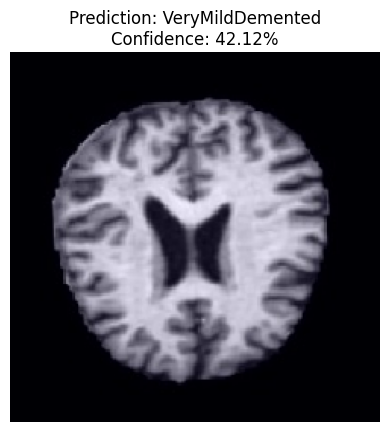

Predicted Class: VeryMildDemented with 42.12% confidence


In [36]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import os

# Define class labels (ensure they match your dataset classes)
class_labels = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

# Function to preprocess an image and make predictions
def predict_image(img_path):
    img = image.load_img(img_path, target_size=(244, 244))  # Match model input shape
  # Resize image
    img_array = image.img_to_array(img) / 255.0  # Normalize pixel values
    print("Image shape before prediction:", img_array.shape)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    prediction = model.predict(img_array)  # Get model predictions
    predicted_class = np.argmax(prediction)  # Get class index
    confidence = np.max(prediction) * 100  # Confidence score

    # Display Image with Prediction
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Prediction: {class_labels[predicted_class]}\nConfidence: {confidence:.2f}%")
    plt.show()

    return class_labels[predicted_class], confidence
# Test on a sample image
TEST_IMAGE_PATH = "AugmentedAlzheimerDataset/VeryMildDemented/2a402e91-f294-4737-8143-0ce26a47f2eb.jpg"
predicted_class, confidence = predict_image(TEST_IMAGE_PATH)

print(f"Predicted Class: {predicted_class} with {confidence:.2f}% confidence")


In [26]:
print(model.input_shape)  # Should match (None, 224, 224, 3)


(None, 244, 244, 3)


In [38]:
model.save("alzheimer_model.h5")  # Saves as a single HDF5 file